In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from pathlib import Path
from torch.utils.data import DataLoader
import random
%load_ext autoreload
%autoreload 2
from dataset.crossView_UCLA_ske import NUCLA_CrossView
from modelZoo.Dyan import Dyan
from modelZoo.Fista import FISTA
import numpy as np

import matplotlib.pyplot as plt
from pandas import DataFrame, set_option
from einops import rearrange, repeat

set_option('display.max_columns', None)
set_option('display.max_rows', None)


def nice_display(arr):
    if arr.ndim == 1:
        display(DataFrame(arr.reshape(1, -1)))
    elif arr.ndim == 2:
        display(DataFrame(arr))
    else:
        display(DataFrame(np.squeeze(arr)))

device = torch.device('cuda:'+str(torch.cuda.current_device()) if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

mseLoss = torch.nn.MSELoss()
l1Loss = torch.nn.L1Loss(reduction='mean')

def running_avg(next, prev, count):
    prev += (next - prev) / (count + 1)
    return prev

def get_uniNorm(skeleton):
    'skeleton: T X 25 x 2, norm[0,1], (x-min)/(max-min)'
    # nonZeroSkeleton = []

    dim = 2

    normSkeleton = np.zeros_like(skeleton)
    visibility = np.zeros(skeleton.shape)
    bbox = np.zeros((skeleton.shape[0], 4))
    for i in range(0, skeleton.shape[0]):
        nonZeros = []
        ids = []
        normPose = np.zeros_like((skeleton[i]))
        for j in range(0, skeleton.shape[1]):
            point = skeleton[i,j]

            if point[0] !=0 and point[1] !=0:

                nonZeros.append(point)
                ids.append(j)

        nonzeros = np.concatenate((nonZeros)).reshape(len(nonZeros), dim)
        minX, minY = np.min(nonzeros[:,0]), np.min(nonzeros[:,1])
        maxX, maxY = np.max(nonzeros[:,0]), np.max(nonzeros[:,1])
        normPose[ids,0] = (nonzeros[:,0] - minX)/(maxX-minX)
        normPose[ids,1] = (nonzeros[:,1] - minY)/(maxY-minY)
        if dim == 3:
            minZ, maxZ = np.min(nonzeros[:,2]), np.max(nonzeros[:,2])
            normPose[ids,2] = (nonzeros[:,1] - minZ)/(maxZ-minZ)
        normSkeleton[i] = normPose
        visibility[i,ids] = 1
        bbox[i] = np.asarray([minX, minY, maxX, maxY])

    return normSkeleton, visibility, bbox

NVIDIA GeForce RTX 2080 Ti


In [10]:
setup = 'setup1'
dataType = '2D'
sampling = 'Single'
nClip = 1
T = 36
maskType = 'None'
bs = 16
nw = 8

path_list = Path().home().joinpath('data', 'N-UCLA_MA_3D')
if path_list.exists():
        path_list = path_list.as_posix() + f"/data/CV/{setup}/"

In [11]:
trainSet = NUCLA_CrossView(root_list=path_list, phase='train',
                            setup=setup, dataType=dataType,
                            sampling=sampling, nClip=nClip,
                            T=T, maskType=maskType) 
trainloader = DataLoader(trainSet, shuffle=True,
                             batch_size=bs, num_workers=nw)


testSet = NUCLA_CrossView(root_list=path_list, phase='test',
                            setup=setup, dataType=dataType,
                            sampling=sampling, nClip=nClip,
                            T=T, maskType=maskType) 
testloader = DataLoader(trainSet, shuffle=False,
                             batch_size=bs, num_workers=nw)


views_train = [samples[0] for samples in trainSet.samples_list]
print(np.unique(views_train, return_counts=True))

views_test = [samples for samples in testSet.samples_list]
print(np.unique(views_test, return_counts=True))

(array(['view_1', 'view_2'], dtype='<U6'), array([516, 504]))
(array(['a01_s01_e00', 'a01_s01_e01', 'a01_s01_e02', 'a01_s01_e03',
       'a01_s01_e04', 'a01_s02_e00', 'a01_s02_e01', 'a01_s02_e02',
       'a01_s02_e03', 'a01_s02_e04', 'a01_s03_e00', 'a01_s03_e01',
       'a01_s03_e02', 'a01_s03_e03', 'a01_s03_e04', 'a01_s03_e05',
       'a01_s03_e06', 'a01_s03_e07', 'a01_s04_e00', 'a01_s04_e01',
       'a01_s04_e02', 'a01_s04_e03', 'a01_s04_e04', 'a01_s06_e00',
       'a01_s06_e01', 'a01_s06_e02', 'a01_s06_e03', 'a01_s06_e04',
       'a01_s07_e00', 'a01_s07_e01', 'a01_s07_e02', 'a01_s07_e03',
       'a01_s07_e04', 'a01_s08_e00', 'a01_s08_e01', 'a01_s08_e02',
       'a01_s08_e03', 'a01_s08_e04', 'a01_s09_e00', 'a01_s09_e01',
       'a01_s09_e02', 'a01_s09_e03', 'a01_s09_e04', 'a01_s10_e00',
       'a01_s10_e01', 'a01_s10_e02', 'a01_s10_e03', 'a01_s10_e04',
       'a02_s01_e00', 'a02_s01_e01', 'a02_s01_e02', 'a02_s01_e03',
       'a02_s01_e04', 'a02_s02_e00', 'a02_s02_e01', 'a02_s02_e02',

In [12]:
mins = []
maxes = []
norms = []
for i, batch in enumerate(trainloader):
    norm_batch = batch['input_skeletons']['normSkeleton']
    for j in range(norm_batch.shape[0]):
        for k in range(norm_batch.shape[1]):
            skeleton = norm_batch[j][k]
            mins.append(skeleton.min())
            maxes.append(skeleton.max())
            norms.append(torch.linalg.vector_norm(skeleton, dim=1))
        
    if i == 0:
        break

min = np.unique(mins, return_counts=True)
max = np.unique(maxes, return_counts=True)
norm = np.unique(norms, return_counts=True)
print(min, max, norm)

(array([0.]), array([576])) (array([1.]), array([576])) (array([0.00000000e+00, 2.42656941e-06, 2.18503483e-05, ...,
       1.41095649e+00, 1.41419808e+00, 1.41421356e+00]), array([716,   1,   1, ...,   1,   1,   6]))


In [ ]:
data['input_skeletons'].keys()
skeleton = data['input_skeletons']['unNormSkeleton']
# print(skeleton.shape)
# get_uniNorm(skeleton)

In [ ]:
max_iter = 10000
lambda_ = 0.04
tol = 1e-5

# dyan = Dyan(device, config_filename='dyan_config')


poles = torch.load('/home/rsl/CVARDIF/model_weights/dir_d_90.pth')['state_dict']
def creatRealDictionary(T, rr, theta, gpu_id):
    WVar = []
    Wones = torch.ones(1).cuda(gpu_id)
    Wones  = Wones
    for i in range(0,T):
        W1 = torch.mul(torch.pow(rr,i) , torch.cos(i * theta))
        W2 = torch.mul (torch.pow(rr,i) , torch.sin(i *theta) )
        W = torch.cat((Wones,W1,W2),0)
        WVar.append(W.view(1,-1))
    dic = torch.cat((WVar),0)

    return dic

D = creatRealDictionary(10, poles['sparseCoding.rr'], poles['sparseCoding.theta'], 0)
# print(D)

Dt = torch.transpose(D, 0, 1)

DtD = torch.matmul(Dt, D)
print(torch.__version__)
print(f'Matrix1 max eigenvalue Matrix = {torch.max(torch.real(torch.linalg.eig(DtD).eigenvalues.cpu()))}')
print(f'Matrix Max eigenvalue by SVD Matrix = {torch.linalg.svdvals(DtD).max()}')
print(f'Flat Matrix Max eigenvalue by SVD Matrix = {torch.linalg.svdvals(DtD.view(-1,1)).max()}')
print(f'torch.linalg.matrix_norm = {torch.linalg.matrix_norm(DtD, ord=2).item()}')
print(f'torch.norm of matrix = {torch.norm(DtD,2)}')


1.9.1+cu111
Matrix1 max eigenvalue Matrix = 187.02980041503906
Matrix Max eigenvalue by SVD Matrix = 187.029541015625
Flat Matrix Max eigenvalue by SVD Matrix = 357.51556396484375
torch.linalg.matrix_norm = 187.029541015625
torch.norm of matrix = 357.51556396484375


In [7]:
mse = 0
l1 = 0
euc = 0
mse_l = []
dyan = Dyan(device, '/home/rsl/CVARDIF/model_weights/dir_d_90_mselossonly.pth')
for i, sample in enumerate(testloader):
    skeletons = sample['input_skeletons']['normSkeleton'].float().cuda(device)
    t = skeletons.shape[1] # (batch_size x num_clips) x t x num_joint x dim_joint
    input_skeletons = skeletons.reshape(skeletons.shape[0], t, -1) 
    # print(input_skeletons.shape)
    Y, C = dyan.forward(input_skeletons)
    # mse = running_avg(mseLoss(Y, input_skeletons), mse, i)
    # l1 = running_avg(l1Loss(Y, input_skeletons), l1, i)
    # euc = running_avg(torch.linalg.norm(Y-input_skeletons, dim=-1).mean(), euc, i)
    mse_l.append(mseLoss(Y, input_skeletons).data.item())

mse = np.asarray(mse_l)
mse = mse.mean()

print(f' mse: {mse}')
# print(f' L1: {l1}')
# print(f' euc: {euc}')

 mse: 8.222752410913606e-07


In [14]:
C[0][:,0].count_nonzero()

tensor(50, device='cuda:0')

In [ ]:
def gridRing(N):
    # epsilon_low = 0.25
    # epsilon_high = 0.15
    # rmin = (1 - epsilon_low)
    # rmax = (1 + epsilon_high)

    # epsilon_low = 0.25
    epsilon_low = 0.15
    epsilon_high = 0.15
    rmin = (1 - epsilon_low)
    rmax = (1 + epsilon_high)

    thetaMin = 0.001
    thetaMax = np.pi - 0.001
    delta = 0.001
    # Npole = int(N / 4)
    Npole = int(N/2)
    Pool = generateGridPoles(delta, rmin, rmax, thetaMin, thetaMax)
    M = len(Pool)

    idx = random.sample(range(0, M), Npole)
    P = Pool[idx]
    # Pall = np.concatenate((P, -P, np.conjugate(P), np.conjugate(-P)), axis=0)
    Pall = np.concatenate((P, np.conjugate(P)), axis=0)  # mirror once

    return P, Pall


## Generate the grid on poles
def generateGridPoles(delta, rmin, rmax, thetaMin, thetaMax):
    rmin2 = pow(rmin, 2)
    rmax2 = pow(rmax, 2)
    print
    xv = np.arange(-rmax, rmax, delta)
    
    x, y = np.meshgrid(xv, xv, sparse=False)
    mask = np.logical_and(np.logical_and(x ** 2 + y ** 2 >= rmin2, x ** 2 + y ** 2 <= rmax2),
                          np.logical_and(np.angle(x + 1j * y) >= thetaMin, np.angle(x + 1j * y) <= thetaMax))
    px = x[mask]
    py = y[mask]
    P = px + 1j * py

    return P


def get_Drr_Dtheta(N):
    P, Pall = gridRing(N)
    Drr = abs(P)
    Drr = torch.from_numpy(Drr).float()
    Dtheta = np.angle(P)
    Dtheta = torch.from_numpy(Dtheta).float()
    return Drr, Dtheta
    # Create some grid poles


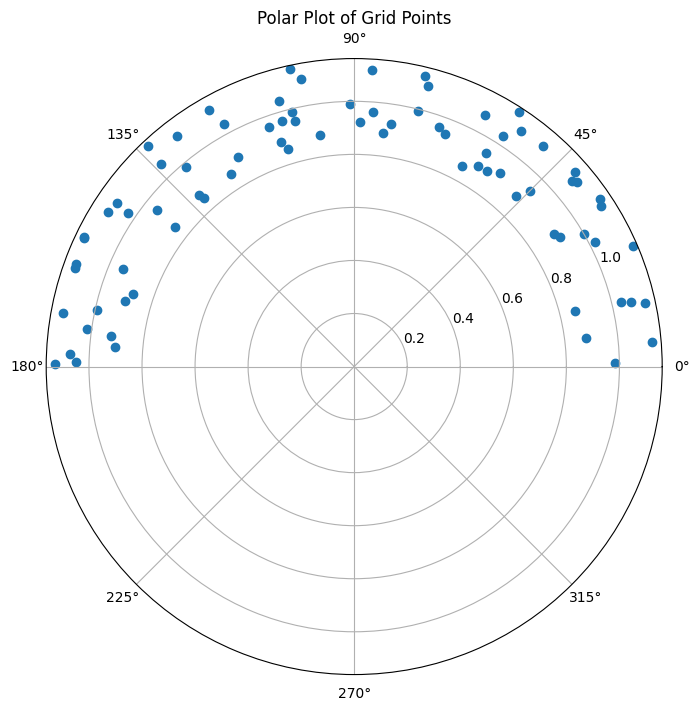

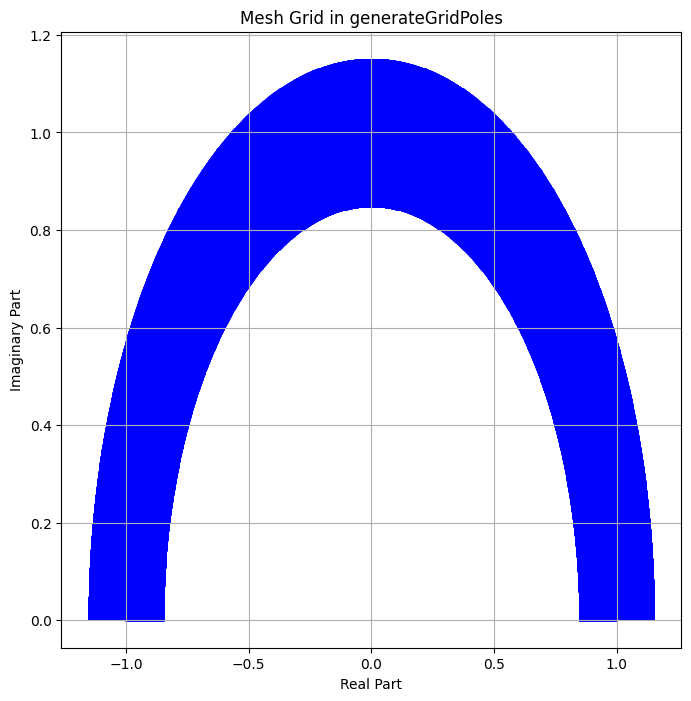

In [ ]:
N = 160
P, Pall = gridRing(N)



[0.4389395 +0.91478668j 0.67574836+0.77844242j 0.515894  +0.82980169j
 0.16601709+0.96713041j 0.93865152+0.6453522j  0.73330805+0.80309006j
 0.11898698+1.01345229j 0.86316315+0.11887774j 0.22249266+0.82664696j
 0.21968905+1.06094023j]


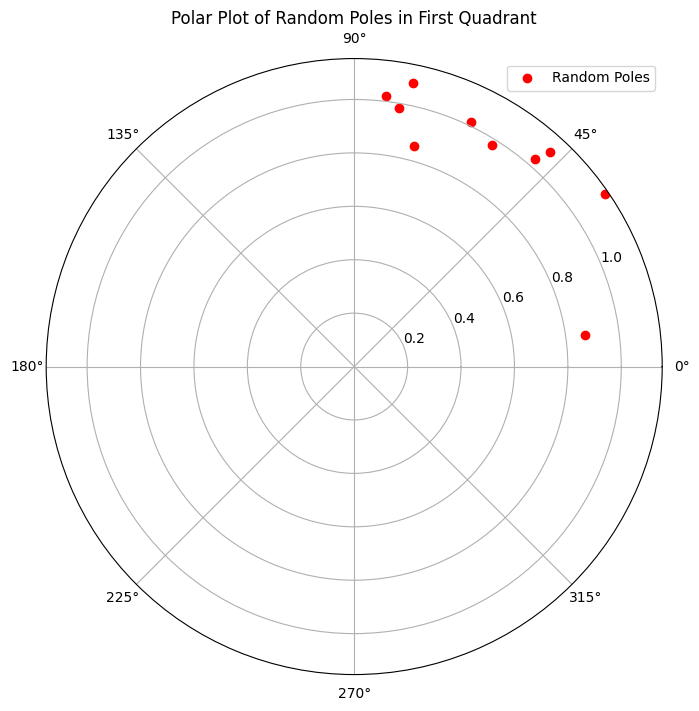

In [ ]:

def generate_random_poles_first_quadrant(num_poles, rmin, rmax, thetaMin, thetaMax):
    poles = []
    while len(poles) < num_poles:
        r = np.random.uniform(rmin, rmax)
        theta = np.random.uniform(thetaMin, thetaMax)
        pole = r * np.exp(1j * theta)
        if np.real(pole) > 0 and np.imag(pole) > 0:
            poles.append(pole)
    return np.array(poles)

num_poles = 10
random_poles = generate_random_poles_first_quadrant(num_poles, rmin, rmax, 0, np.pi/2)



print(random_poles)
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.scatter(np.angle(random_poles), np.abs(random_poles), color='r', label='Random Poles')
ax.set_title('Polar Plot of Random Poles in First Quadrant')
ax.legend()
plt.show()

In [18]:
torch.Tensor([1.0])

tensor([1.])